# Muon Identification

Muon identification with the ePIC detector is a hot topic right now. Muons are produced in a range of key interaction channels under investigation including time-like compton scattering (TCS), Vector Meson Production (J/$\psi$ -> $\mu$$\mu$) and beyond standard model searches. The challenge is that ePIC does **NOT** have dedicated muon detection systems.

Without dedicated systems, we must identify muons from charged tracks and signals in the calorimeters and PID detectors that we do have available. The difficulty is that muons are very similar in mass to pions, so misidentification of one as the other is a big issue.

- $m_{\pi} = 139.57039 MeV/c^{2}$
- $m_{\mu} = 105.66 MeV/c^{2}$

OK, not exactly the same, but quite close. Enough that with the detector resolution we have in HEP systems, it's an issue.

To try to reliably identify muons, we'll need to dive into calorimeter/PID/tracking systems and see if we can distinguish muon signals from other particles. Once we do this for "simple", single particle situations, we can mix in other particles and the move to real physics events.

Ultimately, we want to try and quantify how well we can identify muons with ePIC and hopefully end up with a generic, muon finding algorithm. We can quanitfy the detection in a few ways:

- Efficiency
    - What fraction of muons passing through our system do we detect
- Purity
    - Using our muon finding algorithm, what fraction of our "muons" are actually misidentified pions (or other particles)
- Fake rate
    - At what rate do we falsely identify non-muon particles as muons?
 
We can do this for our particle gun case and then for specific physics channels too.

# Setup

We will need to either download (or stream) some event files in the following locations:

- /volatile/eic/gbxalex/MuonID/Reco/
    - Particle gun files 
- /volatile/eic/gbxalex/September2025_JPsi_RecoOut/
    - Vector meson production files
- /volatile/eic/sjdkay/EpIC_TCS_mumu_18x275/Reco/
    - TCS files
 
We need to run some initial setup commands first. Execute the cells below.

## Setup Code Blocks

### Optional Cell - Run First if using Google Collab

In [ ]:
!pip uninstall --yes cmake ## to work around an xrootd compilation issue on virtual machine
!pip install uproot awkward XRootD numpy pandas matplotlib scipy vector

### Non-Optional - Always Run!

In [2]:
#Import some packages we'll need, specifically, uproot
import uproot as up
import os
import awkward as ak
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.pylab as plt
import vector
from XRootD import client
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors as colours

In [4]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xaxis.labellocation'] = 'right'
plt.rcParams['yaxis.labellocation'] = 'top'
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title]
deg2rad = np.pi/180.0

In [9]:
# See - https://pythonhosted.org/xrootdfs/ - For some details on available commands
# Create XRootD client
eic_server = 'root://dtn-eic.jlab.org/'
fs = client.FileSystem(eic_server)
GunPath = "/volatile/eic/gbxalex/MuonID/Recon/"
VMPath = "/volatile/eic/gbxalex/September2025_JPsi_RecoOut/"
TCSPath = "/volatile/eic/sjdkay/EpIC_TCS_mumu_18x275/Reco/"

## Testing Paths

We can check each path via:

In [10]:
status, files = fs.dirlist(GunPath)
for entry in files:
    print(entry.name)

proton_20GeV_reconOut.root
kaonMinus_20GeV_reconOut.root
piPlus_20GeV_reconOut.root
MuPiKep_Mixed_RecoOut.root
muMinus_20GeV_reconOut.root
piMinus_20GeV_reconOut.root
electron_20GeV_reconOut.root
kaonPlus_20GeV_reconOut.root
muPlus_20GeV_reconOut.root


We see a list of individual roout files. Each is a single particle type except for "MuPiKep_Mixed_RecoOut.root" - which is a mix of all types.

For vector meson production we have:

In [11]:
status, files = fs.dirlist(VMPath)
for entry in files:
    print(entry.name)

10x250ep
10x130ep


Two beam energy combinations, let's check 10x130ep:

In [12]:
status, files = fs.dirlist(VMPath+"/10x130ep")
for entry in files:
    print(entry.name)

reconOut
logs
simOut


The files in reconOut are what we will need later. Finally, for TCS:

In [13]:
status, files = fs.dirlist(TCSPath)
for entry in files:
    print(entry.name)

TCS_events_mumu_plus_68_recon.root
TCS_events_mumu_plus_98_recon.root
TCS_events_mumu_plus_52_recon.root
TCS_events_mumu_plus_21_recon.root
TCS_events_mumu_plus_44_recon.root
TCS_events_mumu_plus_37_recon.root
TCS_events_mumu_plus_7_recon.root
TCS_events_mumu_plus_59_recon.root
TCS_events_mumu_plus_63_recon.root
TCS_events_mumu_plus_10_recon.root
TCS_events_mumu_plus_93_recon.root
TCS_events_mumu_plus_75_recon.root
TCS_events_mumu_plus_85_recon.root
TCS_events_mumu_plus_48_recon.root
TCS_events_mumu_plus_82_recon.root
TCS_events_mumu_plus_72_recon.root
TCS_events_mumu_plus_94_recon.root
TCS_events_mumu_plus_17_recon.root
TCS_events_mumu_plus_64_recon.root
TCS_events_mumu_plus_89_recon.root
TCS_events_mumu_plus_79_recon.root
TCS_events_mumu_plus_30_recon.root
TCS_events_mumu_plus_43_recon.root
TCS_events_mumu_plus_26_recon.root
TCS_events_mumu_plus_55_recon.root
TCS_events_mumu_plus_0_recon.root
TCS_events_mumu_plus_5_recon.root
TCS_events_mumu_plus_19_recon.root
TCS_events_mumu_plus_46

# Streaming Files

The datasets we have at hand this time are a little large to download and run. Instead, we can stream them. Let's start with a particle gun one. We'll first double check our filesizes here too:

In [17]:
status, files = fs.dirlist(GunPath)
flist=[]
for entry in files:
    flist.append(entry.name) # Add all of our entries to a new list, flist

for entry in sorted(flist):
    fname = GunPath + entry
    print(entry," File Size: ",(((fs.stat(fname))[1]).size)/(1024**2), "MB")

MuPiKep_Mixed_RecoOut.root  File Size:  9173.820505142212 MB
electron_20GeV_reconOut.root  File Size:  551.6948347091675 MB
kaonMinus_20GeV_reconOut.root  File Size:  623.7307968139648 MB
kaonPlus_20GeV_reconOut.root  File Size:  570.8038845062256 MB
muMinus_20GeV_reconOut.root  File Size:  604.6560964584351 MB
muPlus_20GeV_reconOut.root  File Size:  605.3360433578491 MB
piMinus_20GeV_reconOut.root  File Size:  2883.4351301193237 MB
piPlus_20GeV_reconOut.root  File Size:  2769.5769052505493 MB
proton_20GeV_reconOut.root  File Size:  580.133563041687 MB


We'll choese muPlus_20GeV_reconOut.root for now:

In [19]:
muPlusFile = eic_server + GunPath + "muPlus_20GeV_reconOut.root"
file=up.open(muPlusFile)
tree = file['events'] 

We're now good to go and we can start analysing this as we did previously in the May workshop. We can check our tree branches quickly for our MC branches via:

In [154]:
tree.keys(filter_name="MC*", recursive=False)

['MCBeamElectrons_objIdx',
 'MCBeamProtons_objIdx',
 'MCNonScatteredElectronAssociations_objIdx',
 'MCParticles',
 'MCParticlesHeadOnFrameNoBeamFX',
 'MCScatteredElectronAssociations_objIdx',
 'MCScatteredElectrons_objIdx',
 'MCScatteredProtons_objIdx']

# Event Display

To try and understand our events, we will also try the EIC event display with our files. This is a bit of a work in progress, so we'll see how it goes and try to get it working for us!

The event display can be found [here](https://github.com/eic/firebird). There are some instructions on running this and a link on this page to running it in our web browser. We'll need to convert some of our files to the right format.

# Workspace

From here on in, this is just space to work. You can start a fresh notebook if you want or just work in new cells below this, it's up to you! To begin with, we'll look at the MC particle distributions and see how our events are actually distributed. We'll start with the muons, then check other particles. 

In [117]:
file.keys()

['events;19', 'events;18', 'podio_metadata;1']

In [118]:
file.classnames()

{'events;19': 'TTree', 'events;18': 'TTree', 'podio_metadata;1': 'TTree'}

In [119]:
tree = file['events']

In [120]:
tree

<TTree 'events' (923 branches) at 0x7f5a39e23560>

In [121]:
tree.keys(recursive=False)

['B0ECalClusterAssociations',
 '_B0ECalClusterAssociations_rec',
 '_B0ECalClusterAssociations_sim',
 'B0ECalClusters',
 '_B0ECalClusters_clusters',
 '_B0ECalClusters_hits',
 '_B0ECalClusters_particleIDs',
 '_B0ECalClusters_shapeParameters',
 '_B0ECalClusters_hitContributions',
 '_B0ECalClusters_subdetectorEnergies',
 'B0ECalRawHitAssociations',
 '_B0ECalRawHitAssociations_rawHit',
 '_B0ECalRawHitAssociations_simHit',
 'B0ECalRawHits',
 'B0ECalRecHits',
 '_B0ECalRecHits_rawHit',
 'B0TrackerCKFTrackAssociations',
 '_B0TrackerCKFTrackAssociations_rec',
 '_B0TrackerCKFTrackAssociations_sim',
 'B0TrackerCKFTrackParameters',
 'B0TrackerCKFTrackParametersUnfiltered',
 'B0TrackerCKFTracks',
 '_B0TrackerCKFTracks_measurements',
 '_B0TrackerCKFTracks_tracks',
 '_B0TrackerCKFTracks_trajectory',
 'B0TrackerCKFTracksUnfiltered',
 '_B0TrackerCKFTracksUnfiltered_measurements',
 '_B0TrackerCKFTracksUnfiltered_tracks',
 '_B0TrackerCKFTracksUnfiltered_trajectory',
 'B0TrackerCKFTrackUnfilteredAssociatio

In [122]:
tree.keys(filter_name="MC*",recursive=False)

['MCBeamElectrons_objIdx',
 'MCBeamProtons_objIdx',
 'MCNonScatteredElectronAssociations_objIdx',
 'MCParticles',
 'MCParticlesHeadOnFrameNoBeamFX',
 'MCScatteredElectronAssociations_objIdx',
 'MCScatteredElectrons_objIdx',
 'MCScatteredProtons_objIdx']

In [123]:
branches=tree["MCParticles"]
branches.keys(recursive=False)

['MCParticles.PDG',
 'MCParticles.generatorStatus',
 'MCParticles.simulatorStatus',
 'MCParticles.charge',
 'MCParticles.time',
 'MCParticles.mass',
 'MCParticles.vertex.x',
 'MCParticles.vertex.y',
 'MCParticles.vertex.z',
 'MCParticles.endpoint.x',
 'MCParticles.endpoint.y',
 'MCParticles.endpoint.z',
 'MCParticles.momentum.x',
 'MCParticles.momentum.y',
 'MCParticles.momentum.z',
 'MCParticles.momentumAtEndpoint.x',
 'MCParticles.momentumAtEndpoint.y',
 'MCParticles.momentumAtEndpoint.z',
 'MCParticles.spin.x',
 'MCParticles.spin.y',
 'MCParticles.spin.z',
 'MCParticles.colorFlow.a',
 'MCParticles.colorFlow.b',
 'MCParticles.parents_begin',
 'MCParticles.parents_end',
 'MCParticles.daughters_begin',
 'MCParticles.daughters_end']

In [124]:
branch = branches['MCParticles.PDG'].array()
print(branch)
print(len(branch))

[[-13], [-13], [-13, 11], [-13], ..., [-13], [-13, 11, 11], [-13, 11, 11, 11]]
50000


In [125]:
print(tree.num_entries)

50000


In [126]:
branches=tree["MCParticles"].arrays()
branches[100]

<Record {'MCParticles.PDG': [-13], ...} type='{"MCParticles.PDG": var * int...'>

In [2]:
tree = file ['events']
tree.keys()

NameError: name 'file' is not defined

In [128]:
print(branches[0].tolist())

{'MCParticles.PDG': [-13], 'MCParticles.generatorStatus': [1], 'MCParticles.simulatorStatus': [33554432], 'MCParticles.charge': [1.0], 'MCParticles.time': [0.0], 'MCParticles.mass': [0.1056583715], 'MCParticles.vertex.x': [0.0], 'MCParticles.vertex.y': [0.0], 'MCParticles.vertex.z': [0.0], 'MCParticles.endpoint.x': [-30000.0], 'MCParticles.endpoint.y': [-14194.621300719302], 'MCParticles.endpoint.z': [-15473.966825077414], 'MCParticles.momentum.x': [-14.874989124956478], 'MCParticles.momentum.y': [-6.654445099080852], 'MCParticles.momentum.z': [-7.521198289327957], 'MCParticles.momentumAtEndpoint.x': [-13.430982088291517], 'MCParticles.momentumAtEndpoint.y': [-6.346306642612163], 'MCParticles.momentumAtEndpoint.z': [-6.930888938754872], 'MCParticles.spin.x': [0.0], 'MCParticles.spin.y': [0.0], 'MCParticles.spin.z': [0.0], 'MCParticles.colorFlow.a': [0], 'MCParticles.colorFlow.b': [0], 'MCParticles.parents_begin': [0], 'MCParticles.parents_end': [0], 'MCParticles.daughters_begin': [0], 

In [138]:
branch = branches['MCParticles.PDG']
for i in range (0,10):
    print(branch[i])

[-13]
[-13]
[-13, 11]
[-13]
[-13]
[-13]
[-13]
[-13]
[-13, 11, 11, 11]
[-13]


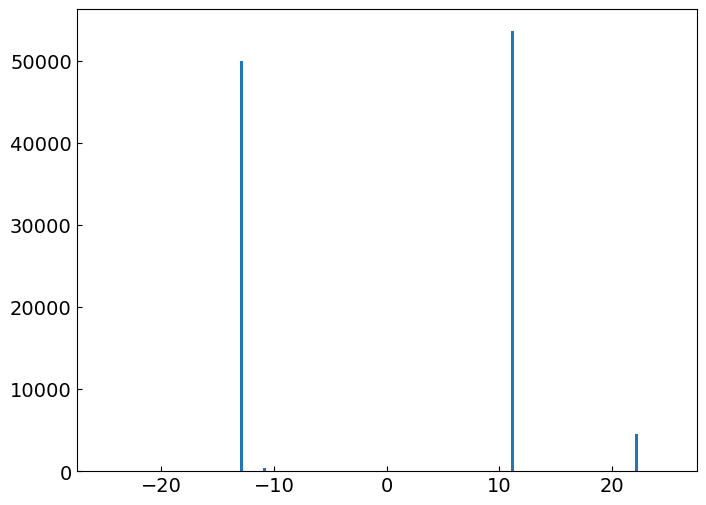

In [40]:

pid = tree['MCParticles'].arrays()
plt.hist(ak.flatten(pid['MCParticles.PDG']),bins =200, range=(-25, 25))
plt.show()


In [131]:
p_x = branches['MCParticles.momentum.x'].arrays()
# print(p_x)
p_y = branches['MCParticles.momentum.y'].arrays()
# print(p_y)
p_z = branches['MCParticles.momentum.z'].arrays()
# print(p_z)

p_x['MCParticles.momentum.x']
p = np.sqrt(p_x['MCParticles.momentum.x']**2+p_y['MCParticles.momentum.y']**2+p_z['MCParticles.momentum.z']**2)
print(p)
plt.hist(ak.flatten(p),bins =100, )
plt.show()


FieldNotFoundError: no field 'MCParticles.momentum.x' in record with 1 fields

In [132]:
tree = file['events']
MCPartBr = tree["MCParticles"].arrays()
MC_Parts = vector.zip({'px': tree["MCParticles.momentum.x"], 'py': tree["MCParticles.momentum.y"], 'pz': tree["MCParticles.momentum.z"]})

print(MC_Parts.eta)
print(MC_Parts.theta)

[]
[]


[[-0.447], [-0.612], ..., [-1.11, ..., -0.372], [-1.4, -0.459, -0.749, -0.885]]
[[2], [2.15], [2.16, ...], ..., [2.5, 2.83, 1.93], [2.66, 2.01, 2.26, 2.36]]


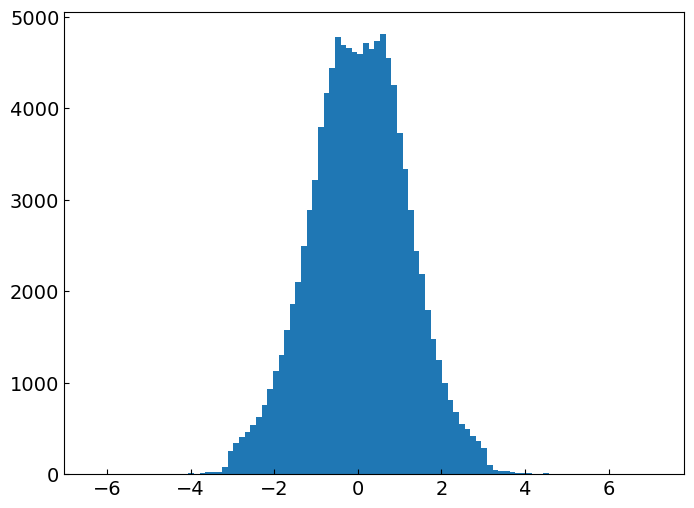

In [133]:
tree = file['events']
MCPartBr = tree["MCParticles"].arrays()
MC_Parts = vector.zip({'px': MCPartBr["MCParticles.momentum.x"], 'py': MCPartBr["MCParticles.momentum.y"], 'pz': MCPartBr["MCParticles.momentum.z"]})
print(MC_Parts.eta)
print(MC_Parts.theta)
plt.hist(ak.flatten(MC_Parts.eta),bins =100, )
plt.show()

/opt/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))


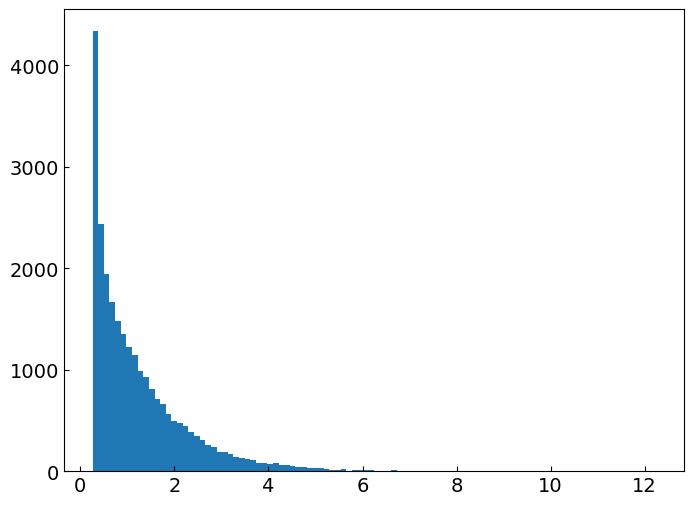

In [163]:
branch=tree['MCParticles.PDG'].arrays()
# ss = branch['MCParticles.generatorStatus'] == 1
muons_only = branch['MCParticles.PDG'] == -13

branch_px= tree["MCParticles.momentum.x"].arrays()
branch_py= tree["MCParticles.momentum.y"].arrays()
branch_pz= tree["MCParticles.momentum.z"].arrays()
branch_m = tree["MCParticles.mass"].arrays()
# plt.hist(ak.flatten(np.sqrt(branch_m["MCParticles.mass"]**2+branch_px["MCParticles.momentum.x"]**2 + branch_py["MCParticles.momentum.y"]**2 + branch_pz["MCParticles.momentum.z"]**2)), bins=25);
# plt.hist(branch)
selected_px = branch_px["MCParticles.momentum.x"][muons_only]
selected_py = branch_py["MCParticles.momentum.y"][muons_only]
selected_pz = branch_pz["MCParticles.momentum.z"][muons_only]
selected_m = branch_m["MCParticles.mass"][muons_only]
energy = np.sqrt(selected_m**2 + selected_px**2 + selected_py**2 + selected_pz**2)
momentum = np.sqrt(selected_px**2 + selected_py**2 + selected_pz**2)
theta = selected_pz /momentum
eta = -np.log(np.tan(theta)/2)
plt.hist(eta,100);

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

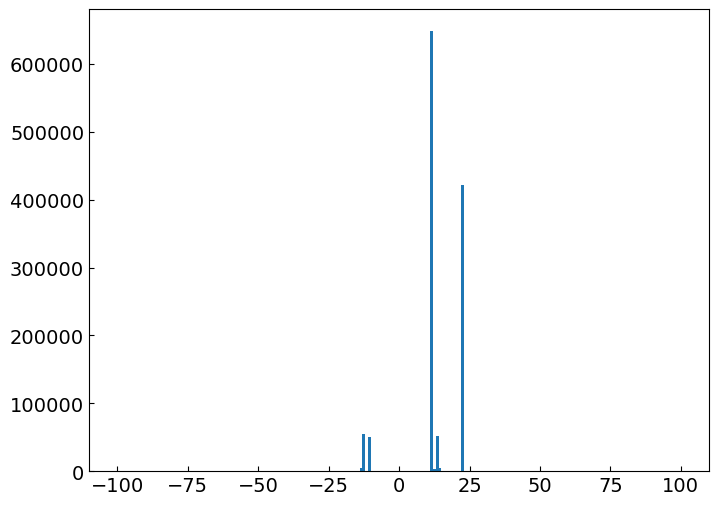

In [113]:
# See - https://pythonhosted.org/xrootdfs/ - For some details on available commands
# Create XRootD client
eic_server = 'root://dtn-eic.jlab.org/'
fs = client.FileSystem(eic_server)
GunPath = "/volatile/eic/gbxalex/MuonID/Recon/"
VMPath = "/volatile/eic/gbxalex/September2025_JPsi_RecoOut/"
TCSPath = "/volatile/eic/sjdkay/EpIC_TCS_mumu_18x275/Reco/"
muPlusFile = eic_server + GunPath + "MuPiKep_Mixed_RecoOut.root"
file=up.open(muPlusFile)
tree = file["events"]
#tree.keys(filter_name = 'MC*', recursive='false')
branches = tree["MCParticles"].arrays()
pion = branches ["MCParticles.PDG"] == 211
#branches.keys(recursive='false')
# pid = branches['MCParticles.PDG'].arrays()
# print(pid)
plt.hist(ak.flatten(branches['MCParticles.PDG']),bins =200, range=(-100, 100))


[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


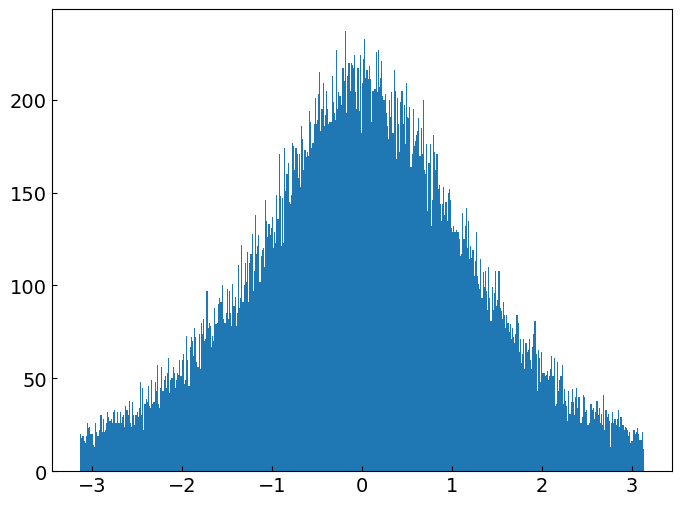

[[-0.343], [0.381], [-0.847], [-0.29], [1.28], [-1.86], ..., [], [], [], [], []]


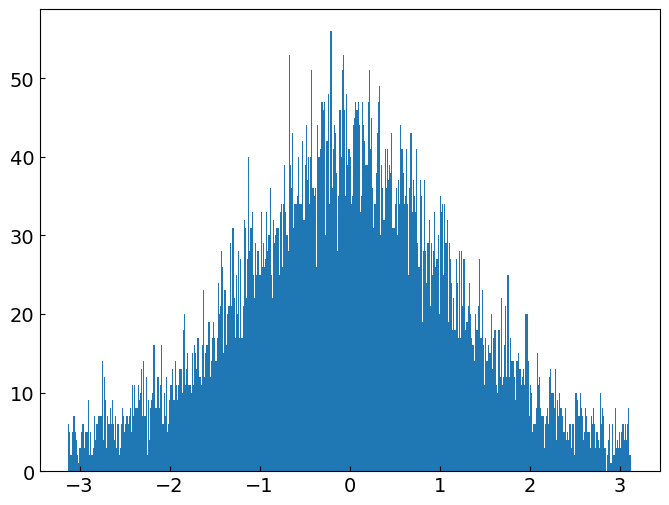

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


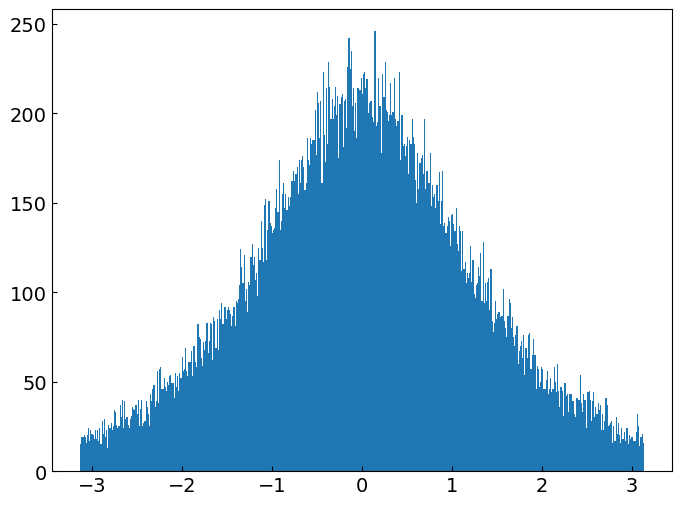

In [94]:
prim_part = branches ["MCParticles.generatorStatus"] == 1
muon = branches ["MCParticles.PDG"] == -13
electron = branches ["MCParticles.PDG"] == 11
pion = branches ["MCParticles.PDG"] == 211
#pion_mom = vector.zip ({'px': branches["MCParticles.momentum.x"][pion][prim_part], 'py': branches["MCParticles.momentum.y"][pion][prim_part], 'pz': branches["MCParticles.momentum.z"][pion][prim_part]})
# mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part], 'py': branches["MCParticles.momentum.y"][prim_part], 'pz': branches["MCParticles.momentum.z"][prim_part]})
muon_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & muon], 'py': branches["MCParticles.momentum.y"][prim_part & muon], 'pz': branches["MCParticles.momentum.z"][prim_part & muon]})
electron_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & electron], 'py': branches["MCParticles.momentum.y"][prim_part & electron], 'pz': branches["MCParticles.momentum.z"][prim_part & electron]})
pion_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & pion], 'py': branches["MCParticles.momentum.y"][prim_part & pion], 'pz': branches["MCParticles.momentum.z"][prim_part & pion]})

# print (mom_vec.eta)
print (muon_mom_vec.eta)

# plt.hist (ak.flatten(mom_vec.eta), bins = 100)
plt.hist (ak.flatten(muon_mom_vec.eta), bins = 500)
plt.show()
# print (mom_vec.eta)

print (electron_mom_vec.eta)
# plt.hist (ak.flatten(mom_vec.eta), bins = 100)
plt.hist (ak.flatten(electron_mom_vec.eta), bins = 500,)
plt.show()

# print (mom_vec.eta)
print (pion_mom_vec.eta)
# plt.hist (ak.flatten(mom_vec.eta), bins = 100)
plt.hist (ak.flatten(pion_mom_vec.eta), bins = 500)
plt.show()
# pion_energy


[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


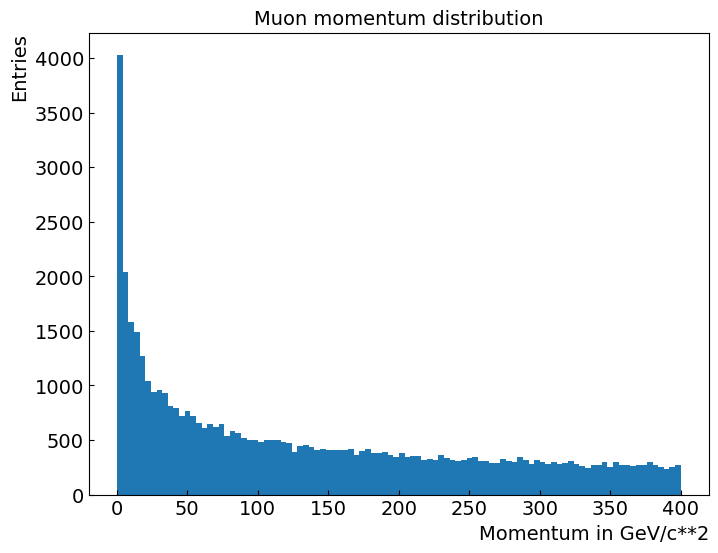

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


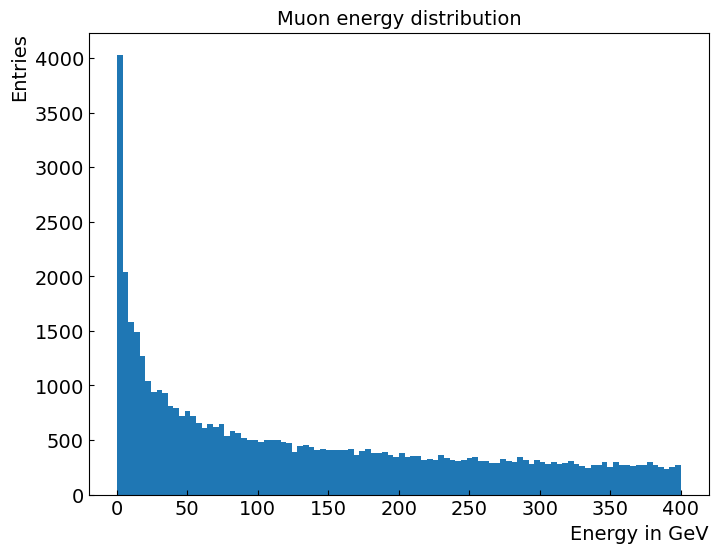

In [136]:
prim_part = branches ["MCParticles.generatorStatus"] == 1
muon = branches ["MCParticles.PDG"] == -13
electron = branches ["MCParticles.PDG"] == 11
pion = branches ["MCParticles.PDG"] == 211
mass = branches ["MCParticles.mass"]
#pion_mom = vector.zip ({'px': branches["MCParticles.momentum.x"][pion][prim_part], 'py': branches["MCParticles.momentum.y"][pion][prim_part], 'pz': branches["MCParticles.momentum.z"][pion][prim_part]})
# mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part], 'py': branches["MCParticles.momentum.y"][prim_part], 'pz': branches["MCParticles.momentum.z"][prim_part]})
muon_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & muon], 'py': branches["MCParticles.momentum.y"][prim_part & muon], 'pz': branches["MCParticles.momentum.z"][prim_part & muon]})
electron_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & electron], 'py': branches["MCParticles.momentum.y"][prim_part & electron], 'pz': branches["MCParticles.momentum.z"][prim_part & electron]})
pion_mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & pion], 'py': branches["MCParticles.momentum.y"][prim_part & pion], 'pz': branches["MCParticles.momentum.z"][prim_part & pion]})
 
muon_mom = muon_mom_vec.mag**2 
print(muon_mom)
plt.hist (ak.flatten(muon_mom), bins=100) 
plt.xlabel ("Momentum in GeV/c**2")
plt.ylabel ("Entries") 
plt.title ("Muon momentum distribution")
plt.show()

muon_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & muon], 'py': branches["MCParticles.momentum.y"][prim_part & muon], 'pz': branches["MCParticles.momentum.z"][prim_part & muon], 'm': branches["MCParticles.mass"][prim_part & muon]})
electron_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & electron], 'py': branches["MCParticles.momentum.y"][prim_part & electron], 'pz': branches["MCParticles.momentum.z"][prim_part & electron], 'm': branches["MCParticles.mass"][prim_part & electron]})
pion_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & pion], 'py': branches["MCParticles.momentum.y"][prim_part & pion], 'pz': branches["MCParticles.momentum.z"][prim_part & pion], 'm': branches["MCParticles.mass"][prim_part & pion]})

muon_4mom = muon_4mom_vec.mag**2
print(muon_4mom)
plt.hist (ak.flatten(muon_4mom), bins=100)
plt.xlabel ("Energy in GeV")
plt.ylabel ("Entries") 
plt.title ("Muon energy distribution")         
plt.show()

[[383], [399], [268], [202], [59.3], [92.6], [309], ..., [], [], [], [], [], []]


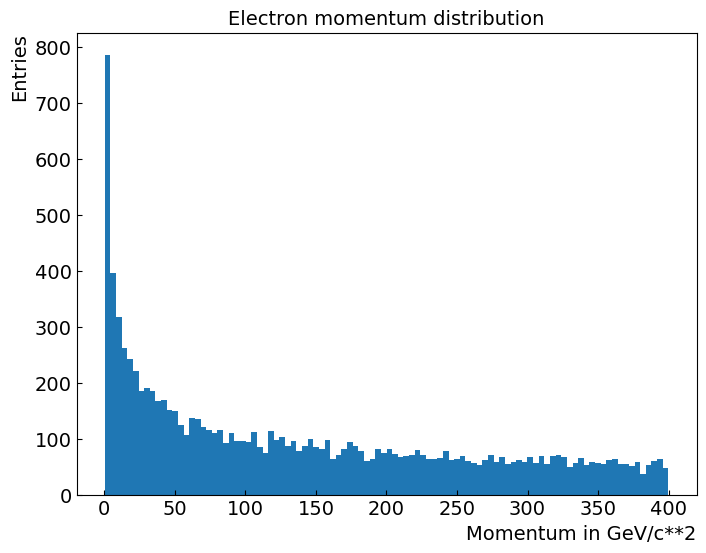

[[383], [399], [268], [202], [59.3], [92.6], [309], ..., [], [], [], [], [], []]


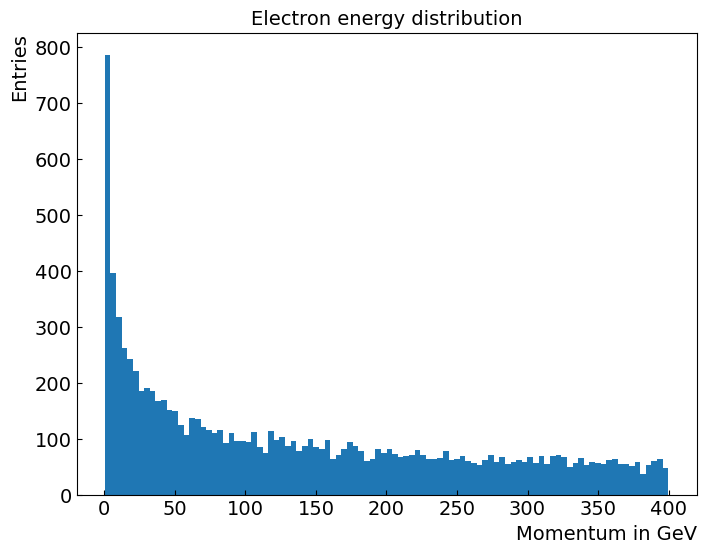

In [133]:
electron_mom = electron_mom_vec.mag**2 
print(electron_mom)
plt.hist (ak.flatten(electron_mom), bins=100) 
plt.xlabel ("Momentum in GeV/c**2")
plt.ylabel ("Entries") 
plt.title ("Electron momentum distribution")
plt.show()

muon_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & muon], 'py': branches["MCParticles.momentum.y"][prim_part & muon], 'pz': branches["MCParticles.momentum.z"][prim_part & muon], 'm': branches["MCParticles.mass"][prim_part & muon]})
electron_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & electron], 'py': branches["MCParticles.momentum.y"][prim_part & electron], 'pz': branches["MCParticles.momentum.z"][prim_part & electron], 'm': branches["MCParticles.mass"][prim_part & electron]})
pion_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & pion], 'py': branches["MCParticles.momentum.y"][prim_part & pion], 'pz': branches["MCParticles.momentum.z"][prim_part & pion], 'm': branches["MCParticles.mass"][prim_part & pion]})

electron_4mom = electron_4mom_vec.mag**2
print(electron_4mom)
plt.hist (ak.flatten(electron_4mom), bins=100)
plt.xlabel ("Energy in GeV")
plt.ylabel ("Entries") 
plt.title ("Electron energy distribution")         
plt.show()

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


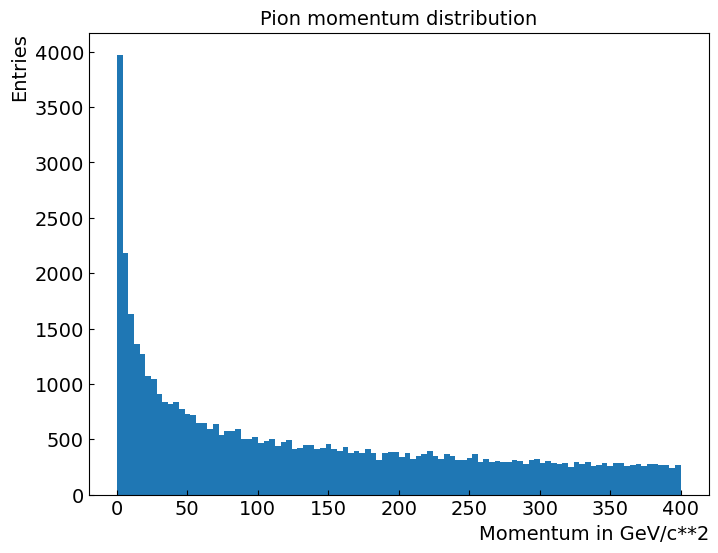

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


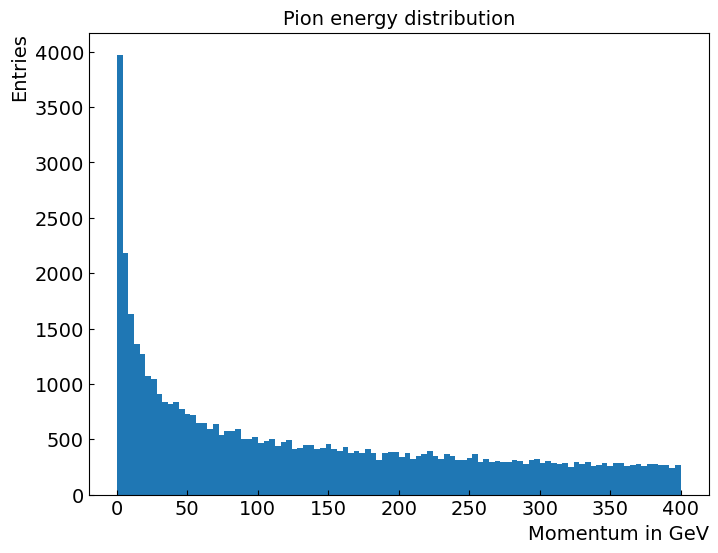

In [134]:
pion_mom = pion_mom_vec.mag**2 
print(pion_mom)
plt.hist (ak.flatten(pion_mom), bins=100) 
plt.xlabel ("Momentum in GeV/c**2")
plt.ylabel ("Entries") 
plt.title ("Pion momentum distribution")
plt.show()

muon_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & muon], 'py': branches["MCParticles.momentum.y"][prim_part & muon], 'pz': branches["MCParticles.momentum.z"][prim_part & muon], 'm': branches["MCParticles.mass"][prim_part & muon]})
electron_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & electron], 'py': branches["MCParticles.momentum.y"][prim_part & electron], 'pz': branches["MCParticles.momentum.z"][prim_part & electron], 'm': branches["MCParticles.mass"][prim_part & electron]})
pion_4mom_vec = vector.zip ({'px': branches["MCParticles.momentum.x"][prim_part & pion], 'py': branches["MCParticles.momentum.y"][prim_part & pion], 'pz': branches["MCParticles.momentum.z"][prim_part & pion], 'm': branches["MCParticles.mass"][prim_part & pion]})

pion_4mom = pion_4mom_vec.mag**2
print(pion_4mom)
plt.hist (ak.flatten(pion_4mom), bins=100)
plt.xlabel ("Momentum in GeV")
plt.ylabel ("Entries") 
plt.title ("Pion energy distribution")         
plt.show()

In [99]:
# See - https://pythonhosted.org/xrootdfs/ - For some details on available commands
# Create XRootD client
eic_server = 'root://dtn-eic.jlab.org/'
fs = client.FileSystem(eic_server)
GunPath = "/volatile/eic/gbxalex/MuonID/Recon/"
VMPath = "/volatile/eic/gbxalex/September2025_JPsi_RecoOut/"
TCSPath = "/volatile/eic/sjdkay/EpIC_TCS_mumu_18x275/Reco/"
muPlusFile = eic_server + GunPath + "MuPiKep_Mixed_RecoOut.root"
file=up.open(muPlusFile)
tree = file["events"]
branchesmc = tree["MCParticles"].arrays()
branches = tree["ReconstructedParticles"].arrays()
print (branchesmc)
print (branches)

[{'MCParticles.PDG': [11, 22, ..., 11, 11], ...}, {...}, ..., {...}, {...}]
[{'ReconstructedParticles.type': [0], ...}, {...}, {...}, ..., {...}, {...}]


52339


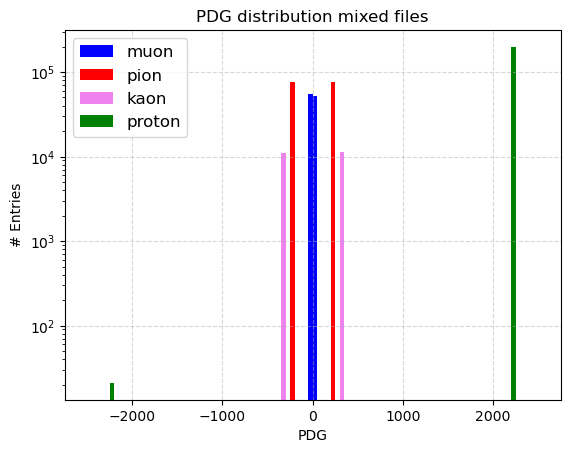

In [130]:
RecoAssoc = tree["ReconstructedChargedParticleAssociations"].arrays()
RecID=RecoAssoc['ReconstructedChargedParticleAssociations.recID'] # Array of reconstructed IDs
SimID=RecoAssoc['ReconstructedChargedParticleAssociations.simID'] # Array of simulated IDs
muons_only=branchesmc["MCParticles.PDG"]== 13
rcp=tree["ReconstructedChargedParticles"].arrays()
BoolMuons=(branchesmc["MCParticles.PDG"][SimID]==13)==(branchesmc["MCParticles.generatorStatus"][SimID]==1) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
# BoolMuons=(branchesmc["MCParticles.PDG"][SimID]==13)==(rcp["ReconstructedChargedParticles.PDG"][RecID]) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
#BoolChargeTrack = ((abs(MCPartBr["MCParticles.charge"][SimID])!=0) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1))
#BoolElec=((MCPartBr["MCParticles.PDG"][SimID]==11) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1))
#BoolPion=((abs(MCPartBr["MCParticles.PDG"][SimID])==211) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1)) # Use abs to include both positive and negative pions
# print(np.asarray(ak.flatten(BoolMuons)).sum())
# plt.hist(ak.flatten(branches["ReconstructedParticles.PDG"][RecID][BoolMuons]), bins=100, range=(-25,25), color='r', label="Rec")
# plt.xlabel('PDG')
# plt.ylabel('# Entries')
# plt.title("$\mu-$ reconstruction")
# plt.show()
BoolMuons_p=(branchesmc["MCParticles.PDG"][SimID]==-13)==(branchesmc["MCParticles.generatorStatus"][SimID]==1) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
# BoolMuons=(branchesmc["MCParticles.PDG"][SimID]==13)==(rcp["ReconstructedChargedParticles.PDG"][RecID]) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
#BoolChargeTrack = ((abs(MCPartBr["MCParticles.charge"][SimID])!=0) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1))
#BoolElec=((MCPartBr["MCParticles.PDG"][SimID]==11) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1))
#BoolPion=((abs(MCPartBr["MCParticles.PDG"][SimID])==211) & (MCPartBr["MCParticles.generatorStatus"][SimID]==1)) # Use abs to include both positive and negative pions
print(np.asarray(ak.flatten(BoolMuons_p)).sum())
pdg = branchesmc["MCParticles.PDG"]

# Select particles (muon, pion, kaon)
muon = pdg ==  13
muonm = pdg ==  -13
pion = pdg == 211
pionm = pdg == -211
kaon = pdg == 321
kaonm = pdg == -321
proton = pdg == 2212
protonm = pdg == -2212
muon_data = ak.flatten(pdg[muon])
pion_data = ak.flatten(pdg[pion])
kaon_data = ak.flatten(pdg[kaon])
proton_data = ak.flatten(pdg[proton])
muon_data_m = ak.flatten(pdg[muonm])
pion_data_m = ak.flatten(pdg[pionm])
kaon_data_m = ak.flatten(pdg[kaonm])
proton_data_m = ak.flatten(pdg[protonm])
plt.hist(muon_data, bins=100, range=(-2500,2500), log = 'true', color='blue', label="muon")
plt.hist(pion_data, bins=100, range=(-2500,2500), log = 'true', color='red', label="pion")
plt.hist(kaon_data, bins=100, range=(-2500,2500), log = 'true', color='violet', label="kaon")
plt.hist(proton_data, bins=100, range=(-2500,2500), log = 'true', color='green', label="proton")
plt.hist(muon_data_m, bins=100, range=(-2500,2500), log = 'true', color='blue')
plt.hist(pion_data_m, bins=100, range=(-2500,2500), log = 'true', color='red')
plt.hist(kaon_data_m, bins=100, range=(-2500,2500), log = 'true', color='violet')
plt.hist(proton_data_m, bins=100, range=(-2500,2500), log = 'true', color='green')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('PDG')
plt.ylabel('# Entries')
plt.title("PDG distribution mixed files")
plt.show()
# plt.hist(ak.flatten(branches["ReconstructedParticles.PDG"][RecID][BoolMuons_p]), bins=100, range=(-25,25), color='r', label="Rec")
# print (branches["ReconstructedParticles.PDG"][RecID][BoolMuons_p])
# plt.xlabel('PDG')
# plt.ylabel('# Entries')
# plt.title("$\mu+$ reconstruction ")
# plt.show()

In [131]:

sel_px_p = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons_p]
sel_py_p = branchesmc["MCParticles.momentum.y"][SimID][BoolMuons_p]
sel_pz_p = branchesmc["MCParticles.momentum.z"][SimID][BoolMuons_p]

print (sel_px)
# s=branches["MCParticles.momentum.x"][SimID]
# print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
mom_vec_mp = vector.zip ({'px': sel_px_p, 'py': sel_py_p, 'pz': sel_pz_p})
plt.hist(ak.flatten(mom_vec_mp.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.title("MC $\mu$+")

plt.show()
plt.hist(ak.flatten(mom_vec_mp.p), bins = 100)
plt.xlabel('momentum (GeV/c)')
plt.ylabel('# Entries')
plt.title("MC $\mu$+")
plt.show()
plt.hist2d(np.asarray(ak.flatten(mom_vec_mp.eta)), np.asarray(ak.flatten(mom_vec_mp.p)), bins = [100,100], cmin=1)
plt.xlabel('$\eta$')
plt.ylabel('momentum (GeV/c)')
plt.colorbar()
plt.title("MC $\mu$+")



<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/59517079.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/59517079.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.title("MC $\mu$+")
/tmp/ipykernel_171/59517079.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.title("MC $\mu$+")
/tmp/ipykernel_171/59517079.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/59517079.py:24: SyntaxWarning: invalid escape sequence '\m'

NameError: name 'sel_px' is not defined

In [132]:

# sel_px_p = branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p]
# sel_py_p = branchesmc["MCParticles.momentum.y"][RecID][BoolMuons_p]
# sel_pz_p = branchesmc["MCParticles.momentum.z"][RecID][BoolMuons_p]

# print (sel_px)
# # s=branches["MCParticles.momentum.x"][SimID]
# # print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
# mom_vec_mp = vector.zip ({'px': sel_px_p, 'py': sel_py_p, 'pz': sel_pz_p})
# plt.hist(ak.flatten(mom_vec_mp.eta), bins = 100)
# plt.xlabel('$\eta$')
# plt.ylabel('# Entries')
# plt.show()
# plt.hist(ak.flatten(mom_vec_mp.p), bins = 100)
# plt.xlabel('momentum (GeV/c)')
# plt.ylabel('# Entries')
# plt.show()
# plt.hist2d(np.asarray(ak.flatten(mom_vec_mp.eta)), np.asarray(ak.flatten(mom_vec_mp.p)), bins = [100,100], cmin=1)
# plt.xlabel('$\eta$')
# plt.ylabel('momentum (GeV/c)')


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/4083763735.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/4083763735.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.title("MC $\mu$-")
/tmp/ipykernel_171/4083763735.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.title("MC $\mu$-")
/tmp/ipykernel_171/4083763735.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/4083763735.py:23: SyntaxWarning: invalid escape seq

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


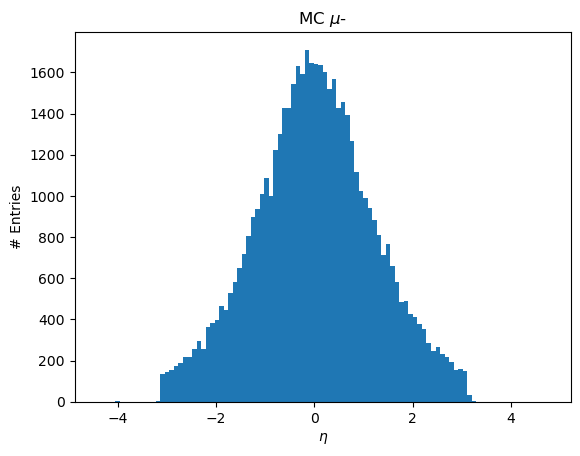

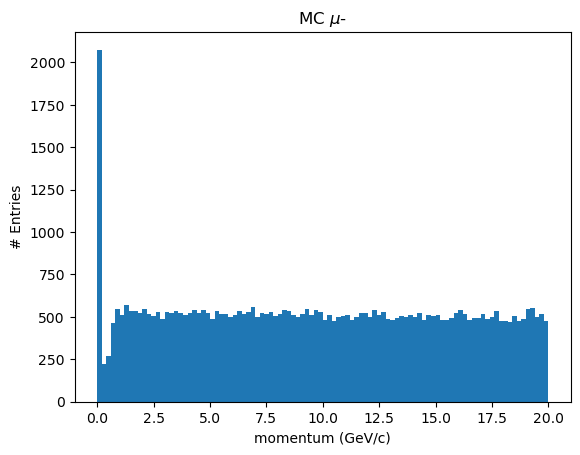

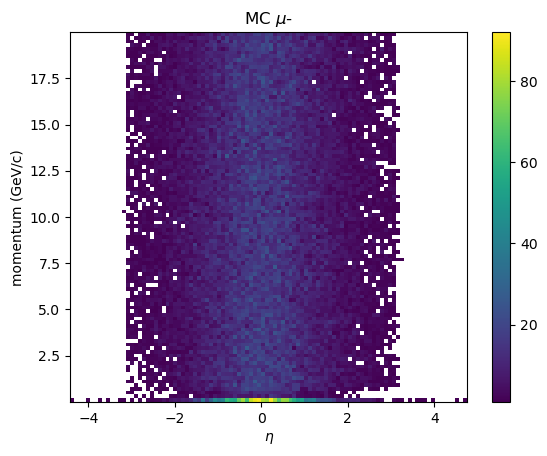

In [133]:

sel_px = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons]
sel_py = branchesmc["MCParticles.momentum.y"][SimID][BoolMuons]
sel_pz = branchesmc["MCParticles.momentum.z"][SimID][BoolMuons]

print (sel_px)
# s=branches["MCParticles.momentum.x"][SimID]
# print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
mom_vec_n = vector.zip ({'px': sel_px, 'py': sel_py, 'pz': sel_pz})
plt.hist(ak.flatten(mom_vec_n.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.title("MC $\mu$-")

plt.show()
plt.hist(ak.flatten(mom_vec_n.p), bins = 100)
plt.xlabel('momentum (GeV/c)')
plt.ylabel('# Entries')
plt.title("MC $\mu$-")
plt.show()
plt.hist2d(np.asarray(ak.flatten(mom_vec_n.eta)), np.asarray(ak.flatten(mom_vec_n.p)), bins = [100,100], cmin=1)
plt.xlabel('$\eta$')
plt.ylabel('momentum (GeV/c)')
plt.title("MC $\mu$-")
plt.colorbar()


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/4097281121.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/4097281121.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Recon $\mu$+")
/tmp/ipykernel_171/4097281121.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Reco $\mu$+")
/tmp/ipykernel_171/4097281121.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/4097281121.py:24: SyntaxWarning: invalid escap

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


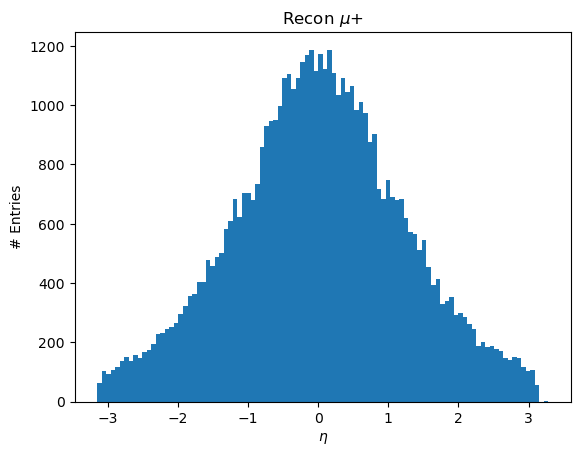

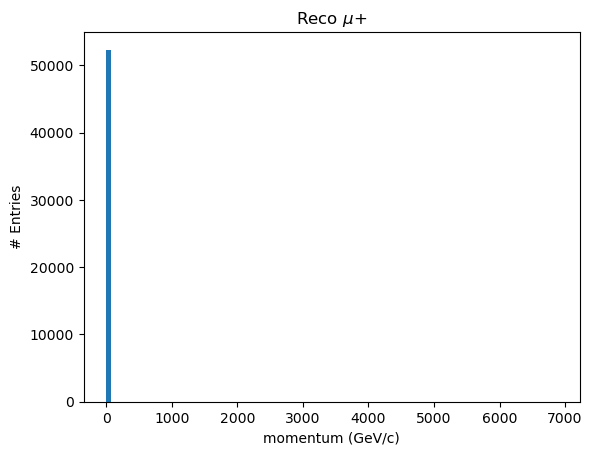

Text(0.5, 1.0, 'Reco $\\mu$+')

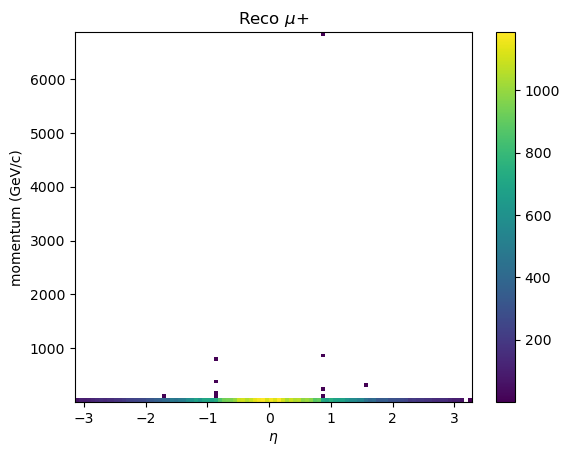

In [134]:
sel_px_r_p = branches["ReconstructedParticles.momentum.x"][RecID][BoolMuons_p]
sel_py_r_p = branches["ReconstructedParticles.momentum.y"][RecID][BoolMuons_p]
sel_pz_r_p = branches["ReconstructedParticles.momentum.z"][RecID][BoolMuons_p]

print (sel_px)
# s=branches["MCParticles.momentum.x"][SimID]
# print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
mom_vec_p = vector.zip ({'px': sel_px_r_p, 'py': sel_py_r_p, 'pz': sel_pz_r_p})
plt.hist(ak.flatten(mom_vec_p.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.title("Recon $\mu$+")

plt.show()
plt.hist(ak.flatten(mom_vec_p.p), bins = 100)
plt.xlabel('momentum (GeV/c)')
plt.ylabel('# Entries')
plt.title("Reco $\mu$+")
plt.show()
plt.hist2d(np.asarray(ak.flatten(mom_vec_p.eta)), np.asarray(ak.flatten(mom_vec_p.p)), bins = [100,100], cmin=1)
plt.xlabel('$\eta$')
plt.ylabel('momentum (GeV/c)')
plt.colorbar()
plt.title("Reco $\mu$+")


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/3025515913.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/3025515913.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Reco $\mu$-")
/tmp/ipykernel_171/3025515913.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Reco $\mu$-")
/tmp/ipykernel_171/3025515913.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/3025515913.py:24: SyntaxWarning: invalid escape

[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


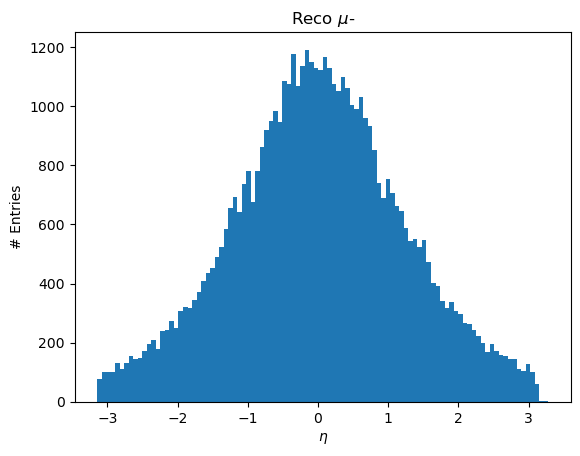

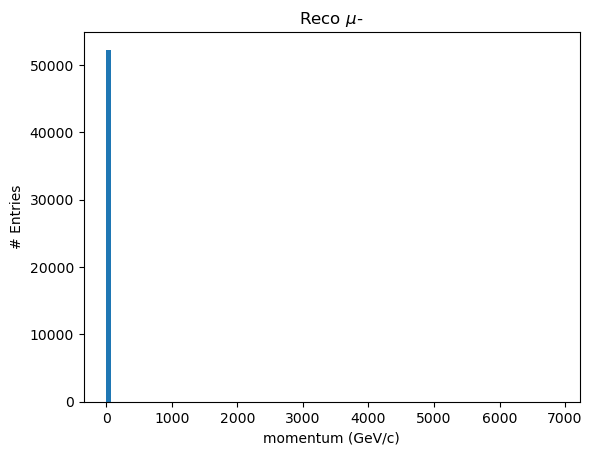

Text(0.5, 1.0, 'Reco $\\mu$-')

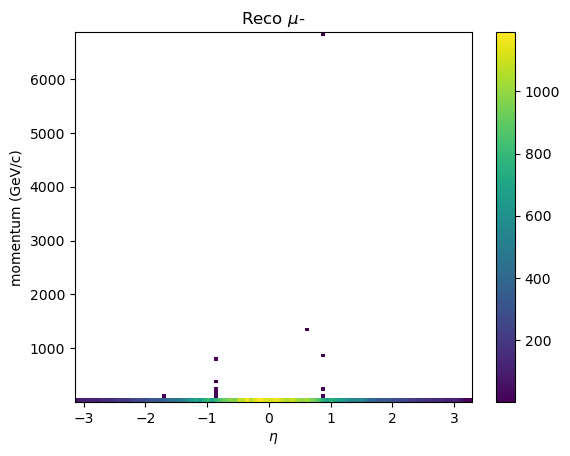

In [135]:
sel_px_r = branches["ReconstructedParticles.momentum.x"][RecID][BoolMuons]
sel_py_r = branches["ReconstructedParticles.momentum.y"][RecID][BoolMuons]
sel_pz_r = branches["ReconstructedParticles.momentum.z"][RecID][BoolMuons]

print (sel_px)
# s=branches["MCParticles.momentum.x"][SimID]
# print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
mom_vec = vector.zip ({'px': sel_px_r, 'py': sel_py_r, 'pz': sel_pz_r})
plt.hist(ak.flatten(mom_vec.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.title("Reco $\mu$-")

plt.show()
plt.hist(ak.flatten(mom_vec.p), bins = 100)
plt.xlabel('momentum (GeV/c)')
plt.ylabel('# Entries')
plt.title("Reco $\mu$-")
plt.show()
plt.hist2d(np.asarray(ak.flatten(mom_vec.eta)), np.asarray(ak.flatten(mom_vec.p)), bins = [100,100], cmin=1)
plt.xlabel('$\eta$')
plt.ylabel('momentum (GeV/c)')
plt.colorbar()
plt.title("Reco $\mu$-")


<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/2386843977.py:39: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Recon $\mu-$")
/tmp/ipykernel_171/2386843977.py:44: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/2386843977.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$-")
/tmp/ipykernel_171/2386843977.py:54: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\eta$')
/tmp/ipykernel_171/2386843977.py:57: SyntaxWarning: invalid escape seq

[[False], [False], [False], [False], ..., [False], [False], [False], [False]]
[[True], [True], [True], [True], ..., [True], [False], [False], [False]]
[[], [], [], [], [], [], [], [], [], ..., [], [], [], [], [], [], [], [], []]


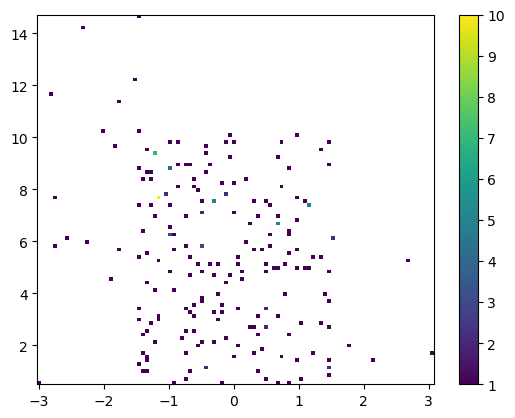

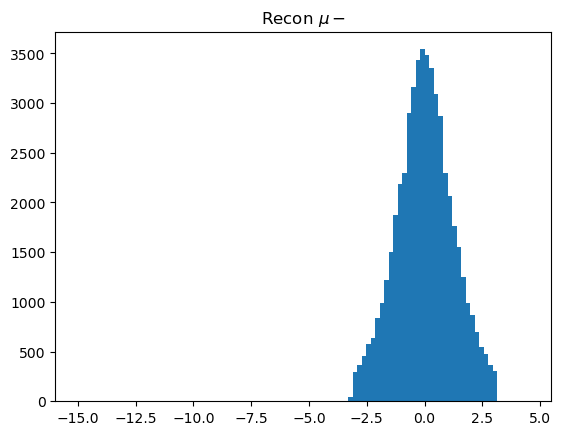

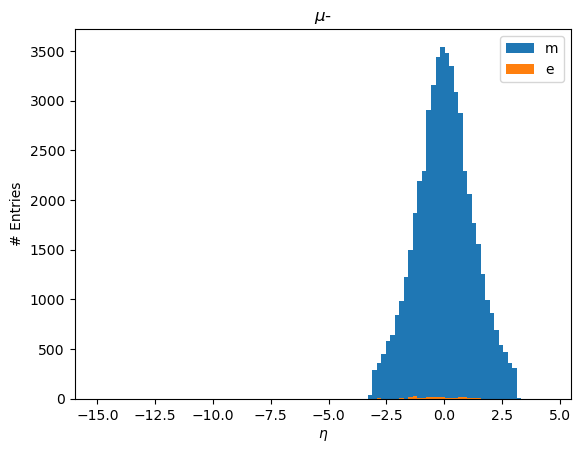

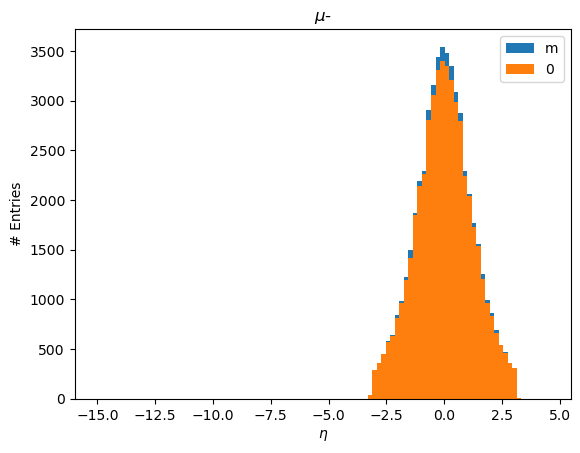

In [136]:
dummy_electron = (branches["ReconstructedParticles.PDG"][RecID] == 11)

sel_px_n_e = branches["ReconstructedParticles.momentum.x"][RecID][BoolMuons & dummy_electron]
sel_py_n_e = branches["ReconstructedParticles.momentum.y"][RecID][BoolMuons & dummy_electron]
sel_pz_n_e = branches["ReconstructedParticles.momentum.z"][RecID][BoolMuons & dummy_electron]
print (dummy_electron)

dummy_0 = (branches["ReconstructedParticles.PDG"][RecID] == 0) 
sel_px_n_0 = branches["ReconstructedParticles.momentum.x"][RecID][BoolMuons & dummy_0]
sel_py_n_0 = branches["ReconstructedParticles.momentum.y"][RecID][BoolMuons & dummy_0]
sel_pz_n_0 = branches["ReconstructedParticles.momentum.z"][RecID][BoolMuons & dummy_0]
print (dummy_0)
# sel_px_p_e = [mom][SimID][BoolMuons_p]
# print (sel_px_p_e)
# sel_px_p_e = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons_p]
# sel_px_p_e = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons_p]

# sel_px_p = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons_p]
# sel_py_p = branchesmc["MCParticles.momentum.y"][SimID][BoolMuons_p]
# sel_pz_p = branchesmc["MCParticles.momentum.z"][SimID][BoolMuons_p]

# print (sel_px)
# # s=branches["MCParticles.momentum.x"][SimID]
# # print (branchesmc["MCParticles.momentum.x"][RecID][BoolMuons_p])
mom_vec_n_e = vector.zip ({'px': sel_px_n_e, 'py': sel_py_n_e, 'pz': sel_pz_n_e})
print (mom_vec_n_e)
mom_vec_n_0 = vector.zip ({'px': sel_px_n_0, 'py': sel_py_n_0, 'pz': sel_pz_n_0})

plt.hist2d(np.asarray(ak.flatten(mom_vec_n_e.eta)), np.asarray(ak.flatten(mom_vec_n_e.p)), bins = [100,100], cmin=1)
plt.colorbar()
plt.show()
# plt.hist2d(np.asarray(ak.flatten(mom_vec_mp_0.eta)), np.asarray(ak.flatten(mom_vec_mp_0.p)), bins = [100,100], cmin=1)
# # plt.xlabel('$\eta$')
# # plt.ylabel('momentum (GeV/c)')
# plt.colorbar()
# plt.show()
# plt.title("MC $\mu$+")
plt.hist(ak.flatten(mom_vec_n.eta), bins = 100, range = (-15,4.5))
plt.title("Recon $\mu-$")
plt.show()
plt.hist(ak.flatten(mom_vec_n.eta), bins = 100, range = (-15,4.5))
plt.hist(ak.flatten(mom_vec_n_e.eta), bins = 100, range = (-15,4.5))
# plt.hist(ak.flatten(mom_vec.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.legend ("me")
plt.title("$\mu$-")

plt.show()

plt.hist(ak.flatten(mom_vec_n.eta), bins = 100, range = (-15,4.5))
plt.hist(ak.flatten(mom_vec_n_0.eta), bins = 100, range = (-15,4.5))
# plt.hist(ak.flatten(mom_vec.eta), bins = 100)
plt.xlabel('$\eta$')
plt.ylabel('# Entries')
plt.legend ("m0")
plt.title("$\mu$-")

plt.show()

In [60]:
file.keys(recursive=False)
tree.keys(recursive=False)
ecal = tree ["HcalBarrelClusters"].arrays()
ecal.keys()


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/162234402.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.title ("Energy distribution of mixed Muons ($\mu+$ and $\mu-$) in HCal")


Text(0.5, 1.0, 'Energy distribution of mixed Muons ($\\mu+$ and $\\mu-$) in HCal')

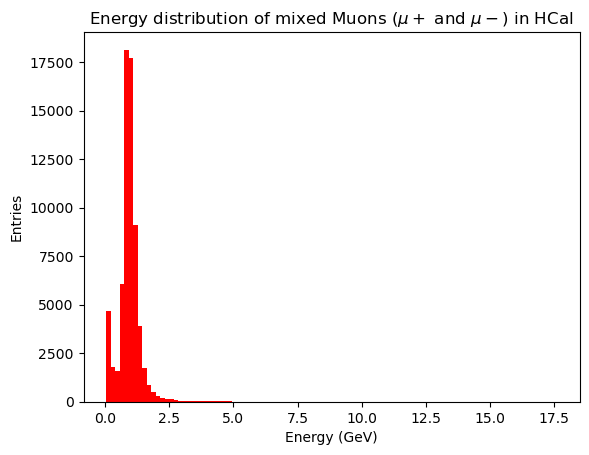

In [150]:
ecal = tree ["HcalBarrelClusters"].arrays()
muon_only = tree["MCParticles.PDG"] == abs(13)
# muon_only_ecal_energy = ecal[muons_only] == abs(13)
ClusterAssoc = tree["HcalBarrelClusterAssociations"].arrays()
Cluster_SimID = ClusterAssoc['HcalBarrelClusterAssociations.simID']
Cluster_RecID = ClusterAssoc['HcalBarrelClusterAssociations.recID']

# ClusterAssoc.keys(recursive=False)
BoolMuons_ecal=(branchesmc["MCParticles.PDG"][Cluster_SimID]==(-13)) | (branchesmc["MCParticles.PDG"][Cluster_SimID]==(13))==(branchesmc["MCParticles.generatorStatus"][Cluster_SimID]==1) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
# print(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal])
plt.hist(ak.flatten(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal]), bins=100, color='r', label="Rec")
plt.xlabel ("Energy (GeV)")
plt.ylabel ("Entries")
plt.title ("Energy distribution of mixed Muons ($\mu+$ and $\mu-$) in HCal")


# print (ClusterAssoc)
# plt.hist (ak.flatten(ClusterAssoc))
# ecal_e = ecal ["EcalBarrelClusters.energy"][ClusterAssoc]
# # ecal_rec = ecal ["EcalBarrelClusters"]
# # ecal.keys()
# ecal_pos_x = ecal ["EcalBarrelClusters.position.x"]
# ecal_pos_y = ecal ["EcalBarrelClusters.position.y"]
# ecal_pos_z = ecal ["EcalBarrelClusters.position.z"]
# # print (ecal_pos_x["EcalBarrelClusters.position.x"])
# # pos_vec= vector.zip({'x': ecal_pos_x, 'y': ecal_pos_y, 'z': ecal_pos_z})
# # print (pos_vec)
# # plt.hist (ak.flatten (pos_vec))
# for i in range (50, 60):
#         print(len(branchesmc["MCParticles.mass"][i]), len(ecal["EcalBarrelClusters.energy"][i]), len(branches["ReconstructedChargedParticles.energy"][BoolMuons][i]))
# # 'EcalBarrelClusterAssociations',
# #  '_EcalBarrelClusterAssociations_rec',
# #  '_EcalBarrelClusterAssociations_sim',

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_171/1719616151.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.title ("Energy distribution of TCS Muons ($\mu+$ and $\mu-$) in ECal")


Text(0.5, 1.0, 'Energy distribution of TCS Muons ($\\mu+$ and $\\mu-$) in ECal')

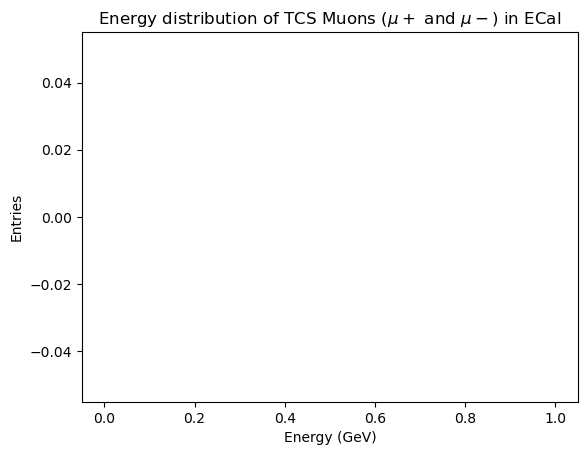

In [75]:
ecal = tree ["EcalBarrelClusters"].arrays()
muon_only = tree["MCParticles.PDG"] == abs(13)
# muon_only_ecal_energy = ecal[muons_only] == abs(13)
ClusterAssoc = tree["EcalBarrelClusterAssociations"].arrays()
Cluster_SimID = ClusterAssoc['EcalBarrelClusterAssociations.simID']
Cluster_RecID = ClusterAssoc['EcalBarrelClusterAssociations.recID']

# ClusterAssoc.keys(recursive=False)
BoolMuons_ecal=(branchesmc["MCParticles.PDG"][Cluster_SimID]==abs(13))==(branchesmc["MCParticles.generatorStatus"][Cluster_SimID]==1) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
# print(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal])
plt.hist(ak.flatten(ecal["EcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal]), bins=100, color='r', label="Rec")
plt.xlabel ("Energy (GeV)")
plt.ylabel ("Entries")
plt.title ("Energy distribution of TCS Muons ($\mu+$ and $\mu-$) in ECal")


# print (ClusterAssoc)
# plt.hist (ak.flatten(ClusterAssoc))
# ecal_e = ecal ["EcalBarrelClusters.energy"][ClusterAssoc]
# # ecal_rec = ecal ["EcalBarrelClusters"]
# # ecal.keys()
# ecal_pos_x = ecal ["EcalBarrelClusters.position.x"]
# ecal_pos_y = ecal ["EcalBarrelClusters.position.y"]
# ecal_pos_z = ecal ["EcalBarrelClusters.position.z"]
# # print (ecal_pos_x["EcalBarrelClusters.position.x"])
# # pos_vec= vector.zip({'x': ecal_pos_x, 'y': ecal_pos_y, 'z': ecal_pos_z})
# # print (pos_vec)
# # plt.hist (ak.flatten (pos_vec))
# for i in range (50, 60):
#         print(len(branchesmc["MCParticles.mass"][i]), len(ecal["EcalBarrelClusters.energy"][i]), len(branches["ReconstructedChargedParticles.energy"][BoolMuons][i]))
# # 'EcalBarrelClusterAssociations',
# #  '_EcalBarrelClusterAssociations_rec',
# #  '_EcalBarrelClusterAssociations_sim',

<function matplotlib.pyplot.show(close=None, block=None)>

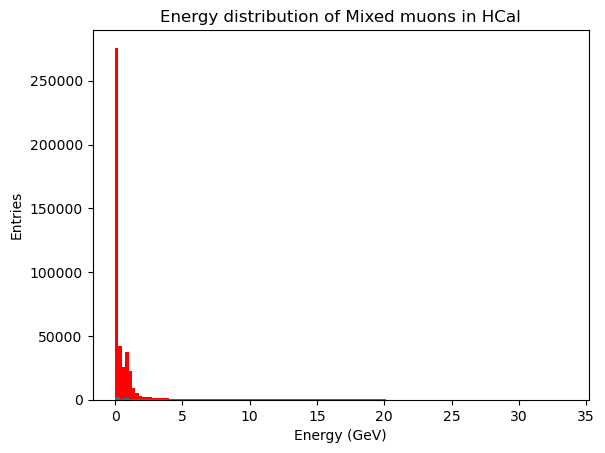

In [176]:
ecal = tree ["HcalBarrelClusters"].arrays()
muon_only = tree["MCParticles.PDG"] == abs(211)
# muon_only_ecal_energy = ecal[muons_only] == abs(13)
ClusterAssoc = tree["HcalBarrelClusterAssociations"].arrays()
Cluster_SimID = ClusterAssoc['HcalBarrelClusterAssociations.simID']
Cluster_RecID = ClusterAssoc['HcalBarrelClusterAssociations.recID']

# ClusterAssoc.keys(recursive=False)
BoolMuons_ecal=(branchesmc["MCParticles.PDG"][Cluster_SimID]==(2212)) | (branchesmc["MCParticles.PDG"][Cluster_SimID]==(-2212))==(branchesmc["MCParticles.generatorStatus"][Cluster_SimID]==4) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
# print(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal])
plt.hist(ak.flatten(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal]), bins=100, range = (0,25), color='r', label="Rec")
plt.hist(ak.flatten(ecal["HcalBarrelClusters.energy"][Cluster_RecID][BoolMuons_ecal]), bins=100, range = (0,25), color='r', label="Rec")

plt.xlabel ("Energy (GeV)")
plt.ylabel ("Entries")
plt.title ("Energy distribution of Mixed muons in HCal")
BoolMuons_p=((branchesmc["MCParticles.PDG"][SimID]==-2212)|(branchesmc["MCParticles.PDG"][SimID]==2212))==(branchesmc["MCParticles.generatorStatus"][SimID]==4) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
sel_px = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons]
sel_py = branchesmc["MCParticles.momentum.y"][SimID][BoolMuons]
sel_pz = branchesmc["MCParticles.momentum.z"][SimID][BoolMuons]
mass = branchesmc["MCParticles.mass"][SimID][BoolMuons]
mom_vec_n = vector.zip ({'px': sel_px, 'py': sel_py, 'pz': sel_pz, 'm': mass})
plt.hist (ak.flatten(mom_vec_n.e), bins = 100)
plt.show

# print (ClusterAssoc)
# plt.hist (ak.flatten(ClusterAssoc))
# ecal_e = ecal ["EcalBarrelClusters.energy"][ClusterAssoc]
# # ecal_rec = ecal ["EcalBarrelClusters"]
# # ecal.keys()
# ecal_pos_x = ecal ["EcalBarrelClusters.position.x"]
# ecal_pos_y = ecal ["EcalBarrelClusters.position.y"]
# ecal_pos_z = ecal ["EcalBarrelClusters.position.z"]
# # print (ecal_pos_x["EcalBarrelClusters.position.x"])
# # pos_vec= vector.zip({'x': ecal_pos_x, 'y': ecal_pos_y, 'z': ecal_pos_z})
# # print (pos_vec)
# # plt.hist (ak.flatten (pos_vec))
# for i in range (50, 60):
#         print(len(branchesmc["MCParticles.mass"][i]), len(ecal["EcalBarrelClusters.energy"][i]), len(branches["ReconstructedChargedParticles.energy"][BoolMuons][i]))
# # 'EcalBarrelClusterAssociations',
# #  '_EcalBarrelClusterAssociations_rec',
# #  '_EcalBarrelClusterAssociations_sim',

52282


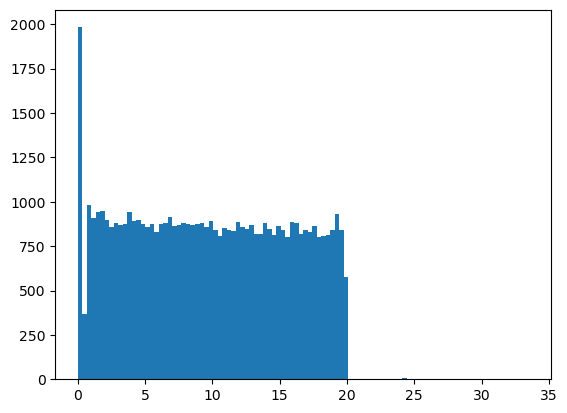

In [178]:
BoolMuons_p=((branchesmc["MCParticles.PDG"][SimID]==-2212)|(branchesmc["MCParticles.PDG"][SimID]==2212))==(branchesmc["MCParticles.generatorStatus"][SimID]==1) # Use simulated or reconstructed IDs as indices, this checks if the pdg between each array matches
sel_px = branchesmc["MCParticles.momentum.x"][SimID][BoolMuons]
sel_py = branchesmc["MCParticles.momentum.y"][SimID][BoolMuons]
sel_pz = branchesmc["MCParticles.momentum.z"][SimID][BoolMuons]
mass = branchesmc["MCParticles.mass"][SimID][BoolMuons]
mom_vec_n = vector.zip ({'px': sel_px, 'py': sel_py, 'pz': sel_pz, 'm': mass})
plt.hist (ak.flatten(mom_vec_n.e), bins = 100)
print(len(ak.flatten(mom_vec_n.e)))